In [1]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.inspection import permutation_importance

import lightgbm as lgb
from lightgbm import LGBMClassifier
import shap

In [3]:
df = pd.read_csv('/content/drive/MyDrive/2차프로젝트/data_v2.csv')
df.head(2)

,yqc_cd,year,quarter,ds,gu_cd,gu_nm,dong_cd,dong_nm,dong_area,business_cd,...,SEL_close_avg,wp_total,rp_total,apt_cnt,apt_price,business_cat,wp_missing,rp_missing,apt_cnt_missing,apt_price_missing
0,20191,2019,1,2019-03-01,11110,종로구,11110515,청운효자동,2568432,CS100001,...,48,6476,13047,342,243371110,음식(한식),0,0,1,1
1,20191,2019,1,2019-03-01,11110,종로구,11110515,청운효자동,2568432,CS100002,...,48,6476,13047,342,243371110,음식(중식),0,0,1,1


In [4]:
## 분기 매출금액 로그 변환
df['qs_log'] = np.log1p(df['qs_total'])

In [5]:
## 시간대 비율 피처 생성
df["qs_1114_r"] = df["qs_1114"] / df["qs_total"] # 점심비율
df['qs_1417_r'] = df['qs_1417'] / df['qs_total'] # 오후비율
df["qs_1721_r"] = df["qs_1721"] / df["qs_total"] # 저녁비율
df["qs_2124_r"] = df["qs_2124"] / df["qs_total"] # 심야비율

In [6]:
## 주중. 주말 비율 피처 생성
df['qs_weekdays_r'] = df['qs_weekdays'] / df['qs_total'] # 주중비율
df['qs_weekend_r'] = df['qs_weekend'] / df['qs_total'] # 주말비율

In [7]:
## 연령대 비율 피처 생성
df["qs_3050_r"] = (df["qs_30"] + df["qs_40"] + df["qs_50"]) / df["qs_total"] # 경제력 & 구매력 소비
df["qs_2030_r"] = (df["qs_20"] + df["qs_30"]) / df["qs_total"] # 유동 + 트렌드 소비
df["qs_60_r"] = df["qs_60"] / df["qs_total"] # 의료/생활소비

In [8]:
## 점포당 매출, 유동인구당 매출, 면적대비 매출 피처 생성
df["qs_per_store"] = df["qs_total"] / (df["store_cnt"])
df["qs_per_pop"] = df["qs_total"] / (df["fp_total"])
df["qs_per_area"] = df["qs_total"] / df["dong_area"]

In [9]:
## 유동인구: 매우 큰 스케일, 분포도 매우 높음 ==> 로그 스케일 적용 필요
## 직장, 상주인구도 동일하게 로그 스케일 적용
df['fp_log'] = np.log1p(df["fp_total"])
df['wp_log'] = np.log1p(df["wp_total"])
df['rp_log'] = np.log1p(df["rp_total"])

In [10]:
df["pop_total"] = df["fp_total"] + df["wp_total"] + df["rp_total"]

df['fp_r'] = df["fp_total"] / df["pop_total"]
df['wp_r'] = df["wp_total"] / df["pop_total"]
df['rp_r'] = df["rp_total"] / df["pop_total"]

In [11]:
## 업종별 점포 밀도
df["store_density"] = df["store_cnt"] / df["dong_area"]

df["similar_density"] = (
    df["similar_store_cnt"] / df["dong_area"]
)

In [12]:
## 경쟁압력지수 (유사업종 점포수 대비 시장규모)
df['comp_pres'] = df['qs_total'] / (df['similar_store_cnt'] + 1)

In [13]:
## 지하철역 로그 변환
## 버스정류장 로그 변환
df['subway_log'] = np.log1p(df['subway_station'])
df["bus_log"] = np.log1p(df["bus_station"])

In [14]:
## 교통입지 점수 --> 지하철역 가중치 적용
df["traffic_score"] = (
    df["subway_log"]*3 +
    df["bus_log"]*1
)

In [15]:
## 아파트 평균 시세 로그 변환
df["apt_log"] = np.log1p(df["apt_price"])

Input(X), Target(Y) 설정

In [16]:
df["growth_rate"] = df.groupby(["dong_cd", "business_cd"])["qs_total"].pct_change()
df

,yqc_cd,year,quarter,ds,gu_cd,gu_nm,dong_cd,dong_nm,dong_area,business_cd,...,wp_r,rp_r,store_density,similar_density,comp_pres,subway_log,bus_log,traffic_score,apt_log,growth_rate
0,20191,2019,1,2019-03-01,11110,종로구,11110515,청운효자동,2568432,CS100001,...,0.001756,0.003538,0.000031,0.000031,2.396394e+07,0.000000,3.295837,3.295837,19.310098,NaN
1,20191,2019,1,2019-03-01,11110,종로구,11110515,청운효자동,2568432,CS100002,...,0.001756,0.003538,0.000002,0.000002,6.123782e+06,0.000000,3.295837,3.295837,19.310098,NaN
2,20191,2019,1,2019-03-01,11110,종로구,11110515,청운효자동,2568432,CS100003,...,0.001756,0.003538,0.000004,0.000004,1.131839e+07,0.000000,3.295837,3.295837,19.310098,NaN
3,20191,2019,1,2019-03-01,11110,종로구,11110515,청운효자동,2568432,CS100004,...,0.001756,0.003538,0.000012,0.000012,3.113409e+07,0.000000,3.295837,3.295837,19.310098,NaN
4,20191,2019,1,2019-03-01,11110,종로구,11110515,청운효자동,2568432,CS100005,...,0.001756,0.003538,0.000007,0.000008,3.190899e+07,0.000000,3.295837,3.295837,19.310098,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404218,20244,2024,4,2024-12-01,11740,강동구,11740700,둔촌2동,1550455,CS300029,...,0.000372,0.003620,0.000006,0.000006,2.056714e+07,0.693147,3.496508,5.575949,19.383703,0.197383
404219,20244,2024,4,2024-12-01,11740,강동구,11740700,둔촌2동,1550455,CS300031,...,0.000372,0.003620,0.000006,0.000006,9.047026e+06,0.693147,3.496508,5.575949,19.383703,1.595698
404220,20244,2024,4,2024-12-01,11740,강동구,11740700,둔촌2동,1550455,CS300033,...,0.000372,0.003620,0.000004,0.000004,4.205920e+07,0.693147,3.496508,5.575949,19.383703,0.657737
404221,20244,2024,4,2024-12-01,11740,강동구,11740700,둔촌2동,1550455,CS300035,...,0.000372,0.003620,0.000011,0.000011,4.592154e+07,0.693147,3.496508,5.575949,19.383703,0.992330


In [17]:
df['growth_rate'].isna().sum()

np.int64(19018)

In [18]:
## 전분기 대비 업종별 총매출 성장률

In [19]:
# 1) 업종-분기 기준으로 총매출 집계
biz_sum = (
    df.groupby(["business_cd", "yqc_cd"])["qs_total"]
      .sum()
      .reset_index()
)

In [20]:
# 2) 업종별로 분기 순서 정렬 후 성장률 계산
biz_sum = biz_sum.sort_values(["business_cd", "yqc_cd"])
biz_sum["qs_business_growth"] = (
    biz_sum.groupby("business_cd")["qs_total"].pct_change()
)

In [21]:
# 3) 원본 df에 merge
df = df.merge(
    biz_sum[["business_cd", "yqc_cd", "qs_business_growth"]],
    on=["business_cd", "yqc_cd"],
    how="left"
)

In [22]:
# 4) 업종 기준 상대성장
df["growth_business_rel"] = df["growth_rate"] - df["qs_business_growth"]

In [23]:
## 전분기 대비 행정동 총매출 성장률

In [24]:
# 1) 행정동-분기 기준으로 총매출 집계
dong_sum = (
    df.groupby(["dong_cd", "yqc_cd"])["qs_total"]
      .sum()
      .reset_index()
)

In [25]:
# 2) 행정동별로 분기 순서 정렬 후 성장률 계산
dong_sum = dong_sum.sort_values(["dong_cd", "yqc_cd"])
dong_sum["qs_dong_growth"] = (
    dong_sum.groupby("dong_cd")["qs_total"].pct_change()
)

In [26]:
# 3) 원본 df에 merge
df = df.merge(
    dong_sum[["dong_cd", "yqc_cd", "qs_dong_growth"]],
    on=["dong_cd", "yqc_cd"],
    how="left"
)

In [27]:
# 4) 행정동 기준 상대성장

In [28]:
df["growth_dong_rel"] =  df["growth_rate"] - df["qs_dong_growth"]

In [29]:
### 성장 점수 ###

In [30]:
df["growth_score"] = (
    df["growth_business_rel"] + df["growth_dong_rel"]
)

In [31]:
df['growth_score'].describe()

,growth_score
count,385205.000000
mean,6.004727
std,1331.169416
min,-8.868663
25%,-0.285800
50%,-0.015337
75%,0.299506
max,743801.836003


In [32]:
quantiles = df["growth_score"].quantile([0, 0.25, 0.5, 0.75, 1.0])
print(quantiles)

0.00        -8.868663
0.25        -0.285800
0.50        -0.015337
0.75         0.299506
1.00    743801.836003
Name: growth_score, dtype: float64


In [33]:
df.nlargest(5, 'growth_score')

,yqc_cd,year,quarter,ds,gu_cd,gu_nm,dong_cd,dong_nm,dong_area,business_cd,...,subway_log,bus_log,traffic_score,apt_log,growth_rate,qs_business_growth,growth_business_rel,qs_dong_growth,growth_dong_rel,growth_score
280983,20231,2023,1,2023-03-01,11590,동작구,11590530,상도1동,1488648,CS300021,...,1.098612,3.871201,7.167038,19.540370,371900.740525,-0.270665,371901.011190,-0.084288,371900.824813,743801.836003
134235,20211,2021,1,2021-03-01,11260,중랑구,11260580,상봉1동,854219,CS300010,...,1.609438,2.564949,7.393263,19.049847,115838.248285,0.019345,115838.228940,-0.777677,115839.025963,231677.254903
362412,20242,2024,2,2024-06-01,11470,양천구,11470510,목1동,1433111,CS300031,...,1.098612,3.401197,6.697034,20.495534,77998.477842,-0.000374,77998.478216,-0.013055,77998.490897,155996.969113
136166,20211,2021,1,2021-03-01,11320,도봉구,11320515,창5동,701480,CS300010,...,1.098612,3.218876,6.514713,18.992326,62928.011735,0.019345,62927.992390,0.429644,62927.582091,125855.574481
106990,20203,2020,3,2020-09-01,11500,강서구,11500603,가양1동,4970691,CS200026,...,1.791759,4.248495,9.623774,19.590218,61513.195584,-0.105119,61513.300703,-0.003973,61513.199557,123026.500260


In [34]:
df['qs_2030'] = df['qs_20'] + df['qs_30']

In [35]:
df['qs_3050'] = df['qs_30'] + df['qs_40'] + df['qs_50']

In [36]:
group_cols = ["dong_cd", "business_cd"]
df = df.sort_values(group_cols + ["yqc_cd"])

In [37]:
# 1) 총매출: 결과 → 누수 방지 위해 비율 X, diff_sqrt O
df["qs_total_diff"] = df.groupby(group_cols)["qs_total"].diff()
df["qs_total_diff_sqrt"] = (
    np.sign(df["qs_total_diff"]) * np.sqrt(np.abs(df["qs_total_diff"]))
)

# 2) 나머지 특성: 원인 → 비율 변화가 인사이트 ↑
pct_cols = [
    "qs_per_store", "store_density", "comp_pres",
    "qs_1114", "qs_1721", "qs_2124",
    "qs_weekdays", "qs_weekend",
    "qs_2030", "qs_3050", "qs_60",

]
for col in pct_cols:
    df[f"{col}_pct"] = df.groupby(group_cols)[col].pct_change()

In [38]:
# group_cols = ["dong_cd", "business_cd"]
# d2 = df.sort_values(group_cols + ["yqc_cd"])

# diff_targets = [
#     "qs_total", "qs_per_store", "store_density", "comp_pres",
#     "qs_1114", "qs_1721", "qs_2124",
#     "qs_weekdays", "qs_weekend",
#     "qs_3050", "qs_2030", "qs_60"
# ]

# for col in diff_targets:
#     df[f"{col}_diff"] = df.groupby(group_cols)[col].diff()

In [39]:
# 1) Target 생성
df["target_label"] = pd.cut(
  df["growth_score"],
  bins=[-np.inf, -0.2, 0.2, np.inf],
  labels=["위축형", "유지형", "성장형"]
)

In [40]:
# 결측치(2019년 1분기) 제거

In [41]:
df['growth_score'].isna().sum()

np.int64(19018)

In [42]:
df2 = df[df["growth_rate"].notna()].copy()

In [43]:
df2['growth_score'].isna().sum()

np.int64(0)

In [44]:
# 2) 수치형 라벨 컬럼 생성
replace_map = {"위축형":0, "유지형":1, "성장형":2}
df2["target"] = df2["target_label"].replace(replace_map).astype(int)

/tmp/ipython-input-2438684886.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2["target"] = df2["target_label"].replace(replace_map).astype(int)
/tmp/ipython-input-2438684886.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df2["target"] = df2["target_label"].replace(replace_map).astype(int)


In [45]:
# 1차 분석 스킵

In [46]:
# 분포 확인
print(df2["target"].value_counts())
print(df2["target"].value_counts(normalize=True))

target
1    149020
0    119550
2    116635
Name: count, dtype: int64
target
1    0.386859
0    0.310354
2    0.302787
Name: proportion, dtype: float64


In [47]:
df2_model = df2[df2["target"].notna()].copy()

In [48]:
feature_cols = [
    # 매출 규모/효율
    "qs_log", "qs_per_store",

    # 시장규모 변화
    "qs_total_diff_sqrt",

    # 경쟁 & 상권
    "store_density","comp_pres",

    # 변화율 기반 원인 피처
    "qs_per_store_pct", "store_density_pct", "comp_pres_pct",
    "qs_1114_pct", "qs_1721_pct", "qs_2124_pct",
    "qs_weekdays_pct", "qs_weekend_pct",
    "qs_2030_pct", "qs_3050_pct","qs_60_pct",

    # 입지
    "fp_log","wp_log","rp_log",
    "subway_station","bus_log","traffic_score",
    "apt_cnt", "apt_log",
]

X = df2_model[feature_cols].copy()
y = df2_model["target"]

In [49]:
print(df2_model["target"].value_counts(normalize=True))

target
1    0.386859
0    0.310354
2    0.302787
Name: proportion, dtype: float64


## LightGBM

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

lgb_params = {
    "objective": "multiclass",
    "num_class": 3,
    "learning_rate": 0.03,
    "num_leaves": 63,
    "max_depth": 8,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "min_child_samples": 50,
    "n_estimators": 2000,
    "metric": "None",
    "random_state": 42,
}

lgb_model = LGBMClassifier(**lgb_params)
lgb_model.fit(
    X_tr, y_tr,
    eval_set=[(X_tr, y_tr), (X_val, y_val)],
    eval_metric="multi_logloss",
)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5616
[LightGBM] [Info] Number of data points in the train set: 246531, number of used features: 24
[LightGBM] [

LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, feature_fraction=0.9,
               learning_rate=0.03, max_depth=8, metric='None',
               min_child_samples=50, n_estimators=2000, num_class=3,
               num_leaves=63, objective='multiclass', random_state=42)

In [51]:
# Validation 성능
y_pred_val = lgb_model.predict(X_val)
print("\n[LGBM Macro F1]", f1_score(y_val, y_pred_val, average="macro"))

# Test 성능
y_pred = lgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print("\n[Test Classification Report]")
print(classification_report(y_test, y_pred))
print(cm)
print("\n[LGBM Test F1]", f1_score(y_test, y_pred, average="macro"))

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9

[LGBM Macro F1] 0.842045943288463
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.88      0.81      0.85     23910
           1       0.77      0.84      0.80     29804
           2       0.89      0.87      0.88     23327

    accuracy       

Validation 점수 vs Test 점수

* 둘이 거의 동일
* 과적합 없고 일반화 성능 안정적
* 모델 / 파라미터 선택이 잘 된 상태

## 성능 근거 & 해석

### 1) Confusion Matrix

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


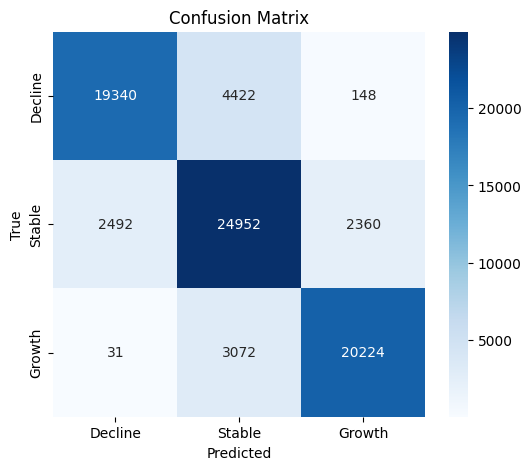

In [52]:
cm = confusion_matrix(y_test, lgb_model.predict(X_test))
class_names = ["Decline","Stable","Growth"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

최종 LightGBM 테스트 성능 해석

| 지표                | 결과                  |
| ----------------- | ------------------- |
| **Macro F1**      | **0.8420 ~ 0.8416** |
| Accuracy          | 0.84                |
| Precision (macro) | 0.85                |
| Recall (macro)    | 0.84                |

---

클래스별 성능

| Class | 의미 (예시) | Precision | Recall | F1   | Support |
| ----- | ------- | --------- | ------ | ---- | ------- |
| **0** | 위축형     | 0.88      | 0.81   | 0.85 | 23,910  |
| **1** | 유지형     | 0.77      | 0.84   | 0.80 | 29,804  |
| **2** | 성장형     | 0.89      | 0.87   | 0.88 | 23,327  |

---

주요 관찰 포인트

1. 유지형(1)

* Precision 낮고 Recall 높음 → 정체형을 실제보다 넓게 긍정 예측하는 경향<br>
→ 정체형을 과대 판단하는 경향 존재

2. 성장형(2)

* 가장 안정적인 클래스 → Precision/Recall/F1 모두 준수

3. 위축형(0)

* Recall이 0.81로 가장 낮음<br>
→ 위축형을 성장형/유지형으로 오판하는 경우 존재

---

Confusion Matrix 해석

[[19340  4422   148]   ← 위축형 일부가 유지형으로 이동<br>
 [ 2492 24952  2360]   ← 유지형 일부가 위축/성장형으로 이동<br>
 [   31  3072 20224]]  ← 성장형 일부가 유지형으로 이동

* 유지형(1)과 성장형(2) 사이 변환이 특히 많음

* 이는 중간 영역 특성이 유사하여 경계가 모호하다는 의미<br>
→ Feature importance/SHAP 분석 시 확인하면 좋음

---

**최종 검토**

* Macro F1 0.84 → 3 Class 불균형 데이터 기준으로 꽤 우수
* 각 클래스 F1 전부 0.80 이상
* Test 성능과 Validation 성능이 크게 차이 없음 → 과적합 아님

결론: 현재 모델 성능은 안정적이며 실무 적용 가능한 수준


### 2) Feature Importance(Gain)

In [53]:
importances = lgb_model.feature_importances_
feature_names = X.columns

fi_gain = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

fi_gain.head(10)

,feature,importance
10,qs_2124_pct,22479
15,qs_60_pct,21606
16,fp_log,21181
8,qs_1114_pct,20733
12,qs_weekend_pct,20497
13,qs_2030_pct,20383
9,qs_1721_pct,19648
14,qs_3050_pct,17787
11,qs_weekdays_pct,16991
18,rp_log,16421


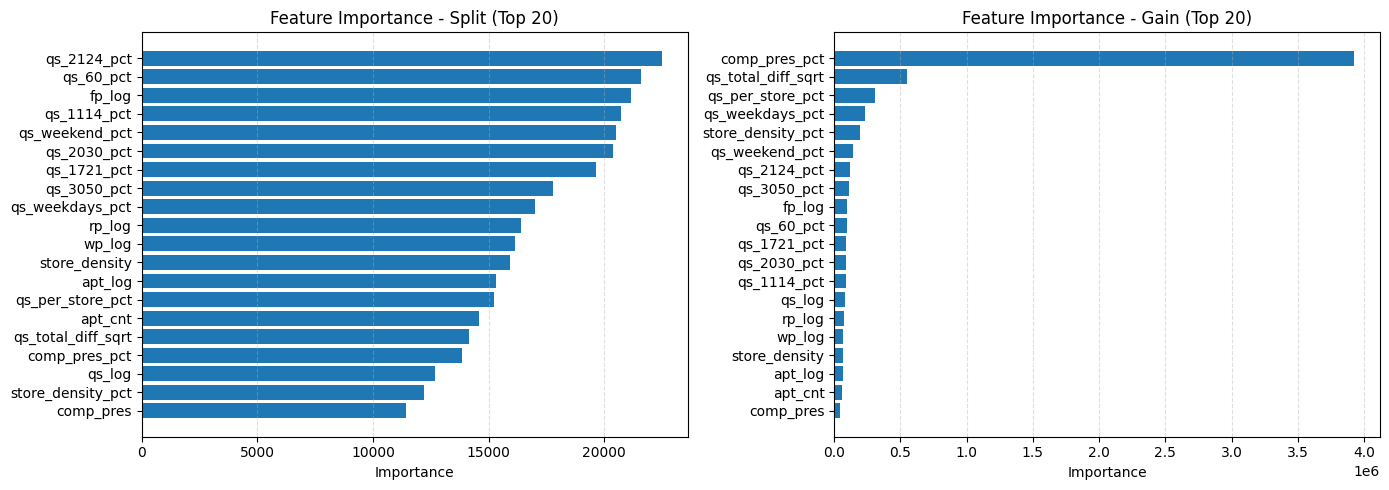

In [54]:
# Feature Names
feature_names = X.columns

# 중요도 가져오기
importance_split = lgb_model.feature_importances_           # Split 기준
importance_gain = lgb_model.booster_.feature_importance("gain")  # Gain 기준

# 시각화를 위해 상위 N개만 사용 (원하면 30개로 변경 가능)
N = 20
idx_split = np.argsort(importance_split)[-N:]
idx_gain = np.argsort(importance_gain)[-N:]

plt.figure(figsize=(14,5))

# Split 기준
plt.subplot(1,2,1)
plt.barh(feature_names[idx_split], importance_split[idx_split])
plt.title("Feature Importance - Split (Top 20)")
plt.xlabel("Importance")
plt.grid(True, axis="x", linestyle="--", alpha=0.4)

# Gain 기준
plt.subplot(1,2,2)
plt.barh(feature_names[idx_gain], importance_gain[idx_gain])
plt.title("Feature Importance - Gain (Top 20)")
plt.xlabel("Importance")
plt.grid(True, axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


### 1, 결과 해석

####Split 기준 결과 (왼쪽 그래프)

* 분기 규칙에 자주 사용된 피처

* 다양한 피처가 고르게 기여

* 상위 피처 대부분 시간대·연령대별 매출 비중(qs_XXX_pct)<br>
→ 상권 특성(유입 패턴)에 의한 분류가 잘 이루어지고 있음

Top 중요 피처

| Feature       | 의미             |
| ------------- | -------------- |
| qs_2124_pct   | 저녁~밤 시간대 매출 비중 |
| qs_60_pct     | 60대 매출 비중      |
| fp_log        | 유동인구 로그        |
| wp_log        | 직장인구 로그        |
| store_density | 주변 점포 밀도       |

*방문 시간대 & 고객 연령대가 핵심 구분요소*

---

#### Gain 기준 결과 (오른쪽 그래프)

* 성능 개선에 크게 기여한 핵심 피처

* 압도적 1위: comp_pres_pct<br>
→ 경쟁압력(유사 경쟁 기반) 변화가 성장/위축 판단에 결정적

| Feature            | 의미                   |
| ------------------ | -------------------- |
| qs_total_diff_sqrt | 전분기 대비 매출 변화량(루트 변환) |
| qs_per_store_pct   | 점포당 매출 비중            |
| qs_weekdays_pct    | 주중 매출 비중             |

*경쟁 압력 + 매출 변화 자체 → 성장판단에 가장 큰 영향*

---

### 핵심 인사이트 요약

| 구분              | 의미           | 정책적 해석          |
| --------------- | ------------ | --------------- |
| **Split 기준 상위** | 상권 특성(유입 패턴) | 어떤 상권인지 분류에 중요  |
| **Gain 기준 상위**  | 매출 변화 & 경쟁압력 | 성장형/위축형 구분에 결정적 |

➡ 즉,<br>
기본적으로 상권 특성으로 상권 유형을 구분하고<br>
그 안에서 경쟁압력과 매출성장 변화로 성/위축 판단

### 3) SHAP

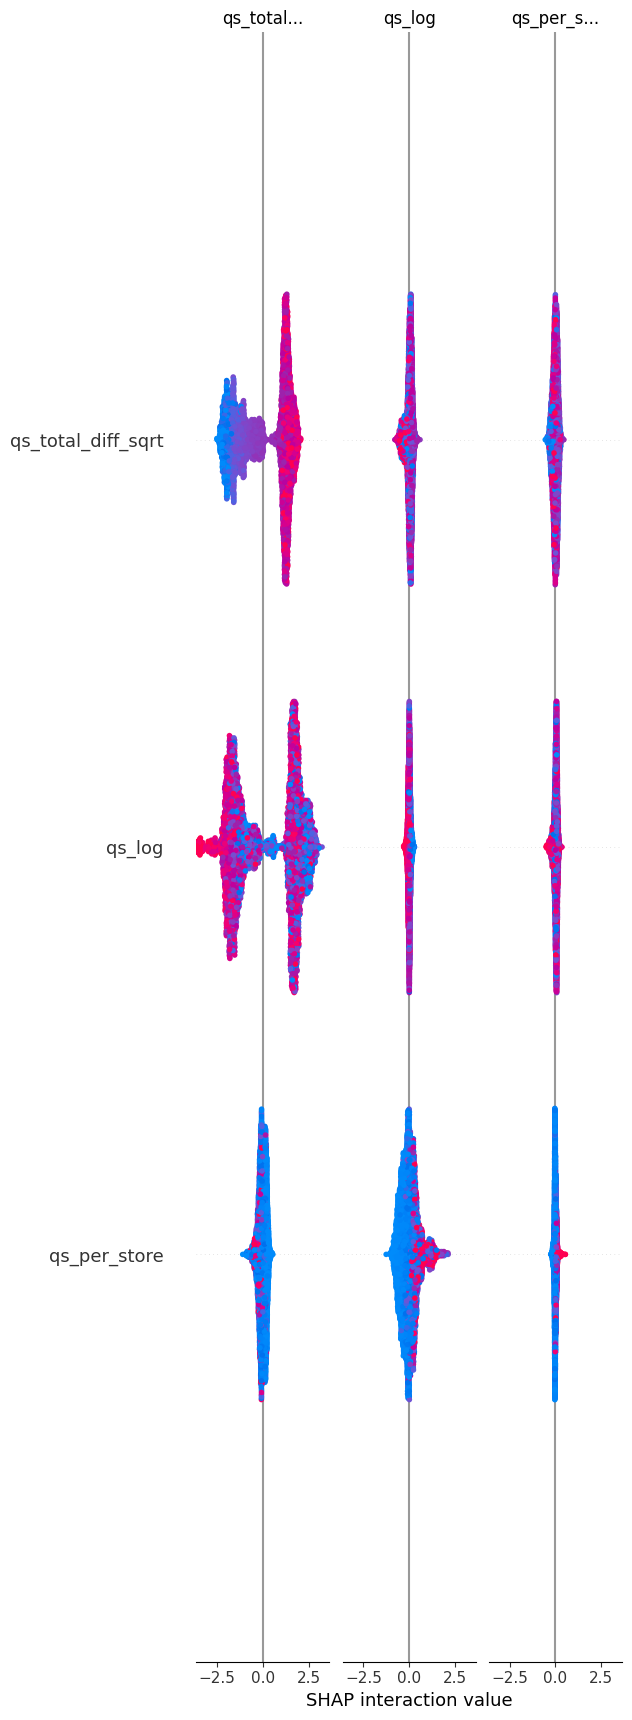

In [55]:
X_sample = X_test.sample(5000, random_state=42)

explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, plot_type="dot", max_display=20)

## SHAP Interaction Plot

### SHAP Interaction 해석 핵심

X축: SHAP 값 → 성장형 방향으로 얼마나 영향?

색깔

* 🔵 파란색 = 예측값 낮은 구역(대체로 Decline 방향)

* 🔴 빨간색 = 예측값 높은 구역(대체로 Growth 방향)

위치

* 오른쪽(+): Growth 쪽으로 기여

* 왼쪽(-): Decline 쪽으로 기여

---

1. qs_total_diff_sqrt

최근 매출 변화량 (성장 신호)

| 패턴          | 의미                     |
| ----------- | ---------------------- |
| 오른쪽이 빨간색 밀집 | 매출이 늘어나는 곳 → 성장형 확률 ↑↑ |
| 왼쪽이 파란색 밀집  | 매출 감소 구간 → 위축형 가능성 ↑↑  |

**결정적 성장지표**<BR>
직전 대비 매출 상승이 발생하면 성장형으로 전환될 확률이 크게 올라감

---

2. qs_log

총매출 규모(로그)

| 패턴               | 의미              |
| ---------------- | --------------- |
| 높은 값(붉은색)일수록 +방향 | **큰 상권이 더 성장형** |
| 낮은 값(파란색)은 -방향   | 작은 상권은 하향 가능성   |

규모경제 + 상권의 기본 체력<br>
총매출이 낮은 상권은 **성장으로 가기 어려움**

3. qs_per_store

점포당 매출 효율

| 패턴             | 의미                 |
| -------------- | ------------------ |
| 높은 값(붉은색)이 오른쪽 | **효율 좋은 상권 → 성장형** |
| 낮은 값(파란색)이 왼쪽  | 비효율 상권 → 위축형       |

**경쟁 대비 운영 효율이 성패 가른다**<br>
(점포 증가 = 위험이 아니라 효율이 핵심 지표)

---

### 통합 결론 (보고서 문구)

>**최근 매출 증가, 상권 자체 매출 규모, 점포당 매출 효율**이
상권의 **성장성을 결정짓는 핵심 요인**으로 확인됨.

특히,

* 매출이 증가하는 시그널이 나타나면

* 상권이 충분한 규모를 확보하고 있다면

* 점포당 매출 효율이 낭비 없이 유지된다면

→ 성장형으로 빠르게 전환

반대로

* 매출 감소 추세
* 작은 규모의 상권
* 점포 효율 낮음

→ **위축형에 가까움**

---

### 서비스 관점 인사이트

| 상권 상태         | 정책/운영 전략           |
| ------------- | ------------------ |
| 효율 ↑ + 매출 증가↑ | 투자 유망 / 신규업종 안착 가능 |
| 효율 ↓ + 경쟁↑    | **폐점 리스크 경고**      |
| 주말·야간 수요↑     | 여가/외식 중심 업종 추천     |
| 평일 중심 + 매출보합  | 직장인 수요 업종 유지       |

>설명 가능한 AI(상권 추천 엔진)로서
매우 설득력 있는 근거 추출이 완료된 상태

In [59]:
for name in list(globals().keys()):
    if name not in ["lgb_model", "X_test", "y_test", "pd", "np", "shap"]:
        del globals()[name]

In [60]:
# 샘플링 후 SHAP 계산
# 샘플 5000개 선택 (같은 index 사용)
sample_index = X_test.sample(5000, random_state=42).index

X_sample = X_test.loc[sample_index].reset_index(drop=True)
y_sample = y_test.loc[sample_index].reset_index(drop=True)

# SHAP 계산
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_sample)

#### a. 전체 Summary Plot

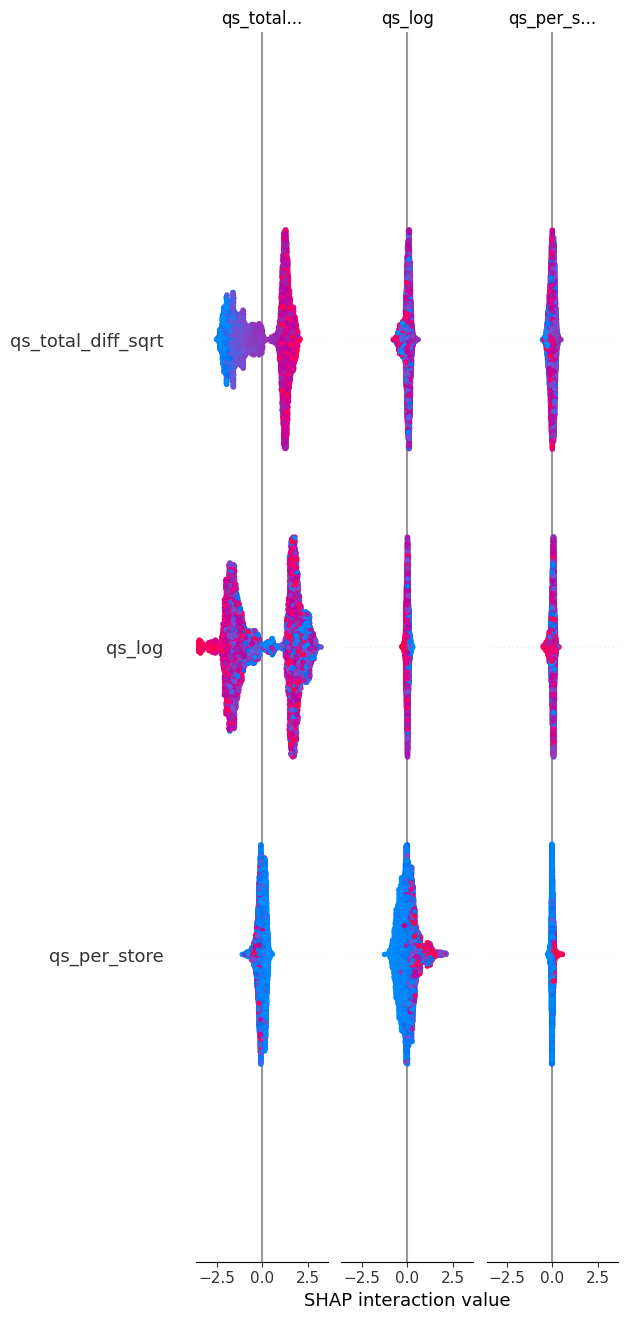

In [57]:
# 전체 Summary Plot
shap.summary_plot(shap_values, X_sample, plot_type="dot", max_display=15)

#### b. 클래스별 Summary Plot

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


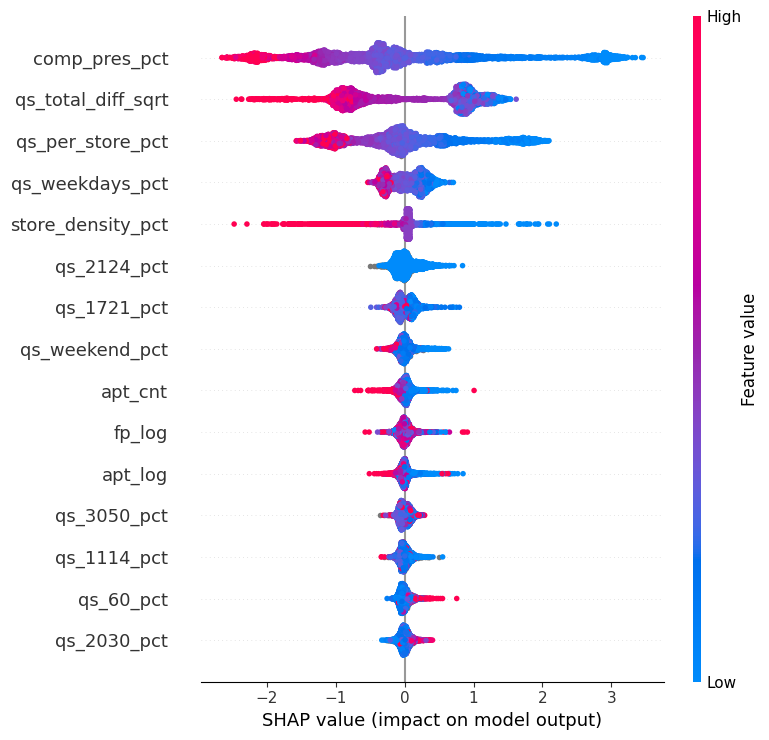

In [66]:
# Decline (class 0)
shap.summary_plot(shap_values[:, :, 0], X_sample, plot_type="dot", max_display=15)

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


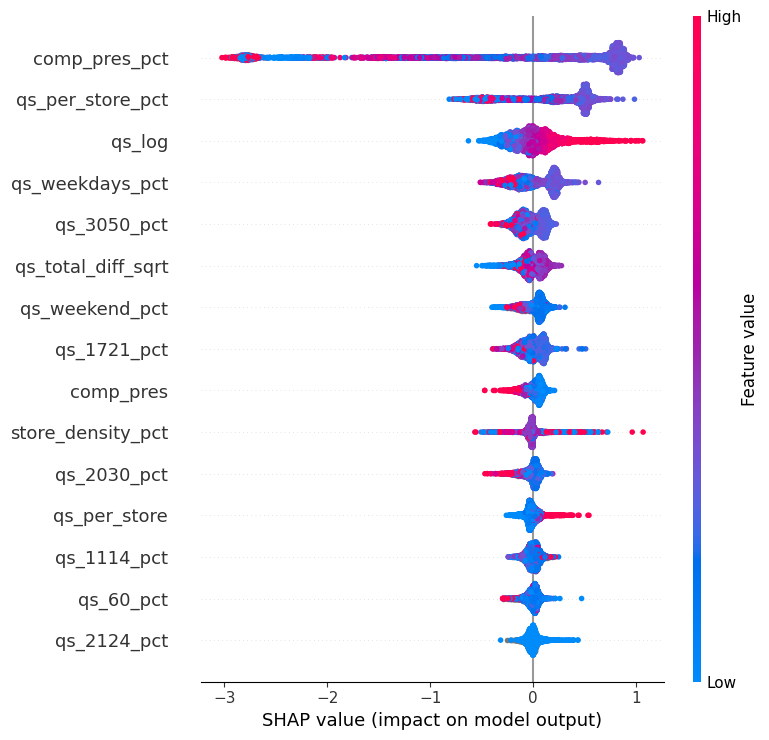

In [67]:
# Stable (class 1)
shap.summary_plot(shap_values[:, :, 1], X_sample, plot_type="dot", max_display=15)

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


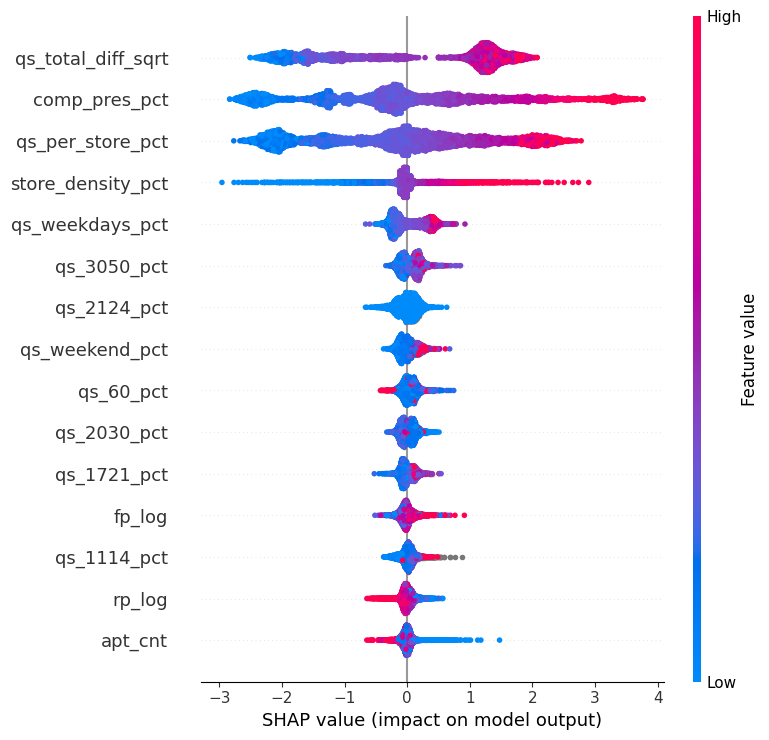

In [68]:
# Growth (class 2)
shap.summary_plot(shap_values[:, :, 2], X_sample, plot_type="dot", max_display=15)